### Load Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SECTORS = {
    "Technology": ["NVDA", "AAPL", "MSFT"],
    "Financial": ["JPM", "V", "BAC"],
    "Consumer Goods": ["WMT", "COST", "PG"]
}

BENCHMARK = "^GSPC"

def load_cleaned_data(sector, ticker):
    filepath = f"../data/processed/{sector}/{ticker}_cleaned.csv"
    try:
        df = pd.read_csv(filepath, parse_dates=["Date"])
        return df
    except Exception as e:
        print(f"Error loading {ticker}: {e}")
        return None
    
all_data = {}

benchmark_data = load_cleaned_data("Benchmark", BENCHMARK)
if benchmark_data is not None:
    all_data[BENCHMARK] = benchmark_data

for sector, tickers in SECTORS.items():
    for ticker in tickers:
        df = load_cleaned_data(sector, ticker)
        if df is not None:
            all_data[ticker] = df

### Closing Price Graph

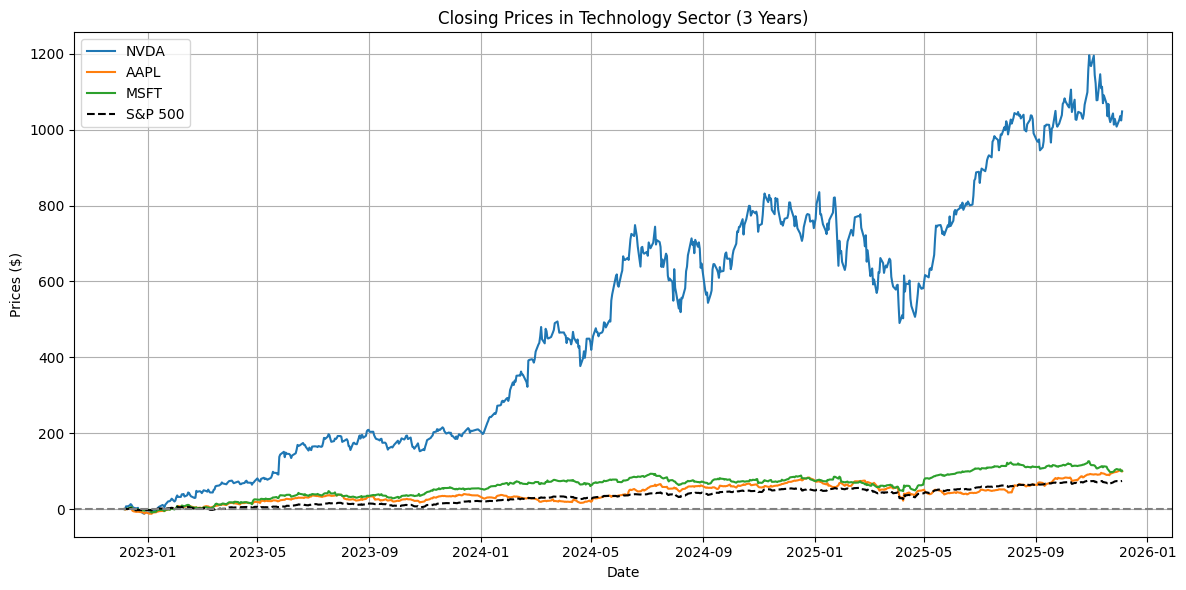

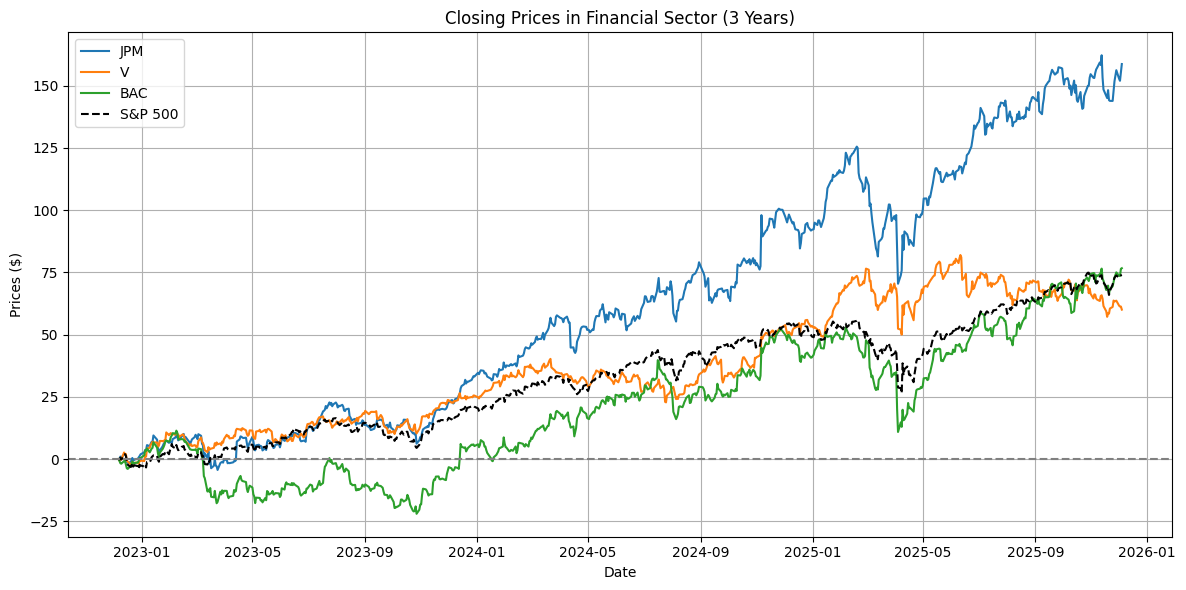

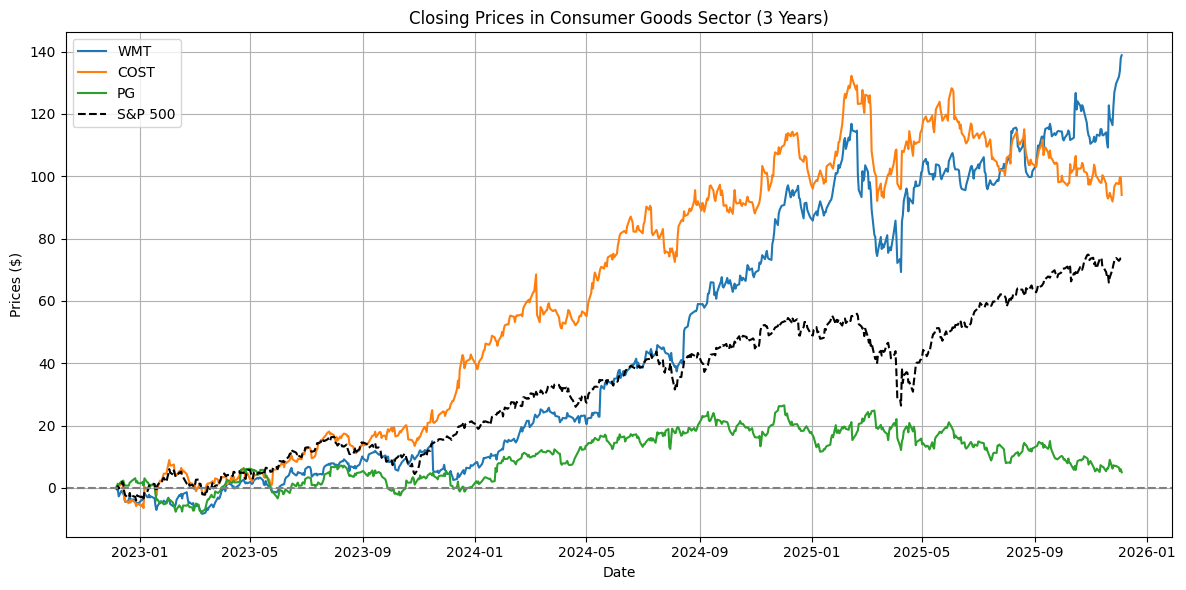

In [22]:
def closing_price_by_sector_plot(all_data, benchmark_data):
    for sector, tickers in SECTORS.items():
        fig, ax = plt.subplots(figsize=(12, 6))

        for ticker in tickers:
            if ticker in all_data:
                df = all_data[ticker]
                normalized = (df['Close'] / df['Close'].iloc[0] - 1) * 100
                ax.plot(df['Date'], normalized, label=ticker)

        if benchmark_data is not None:
            normalized_benchmark = (benchmark_data['Close'] / benchmark_data['Close'].iloc[0] - 1) * 100
            ax.plot(benchmark_data['Date'], normalized_benchmark, label='S&P 500', color='black', linestyle='--')

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.set_title(f"Closing Prices in {sector} Sector (3 Years)")
        ax.set_xlabel('Date')
        ax.set_ylabel('Prices ($)')
        ax.legend()
        ax.grid()
        plt.tight_layout()
        plt.show()
        plt.close() 

closing_price_by_sector_plot(all_data, benchmark_data)

### Moving Averages Plot

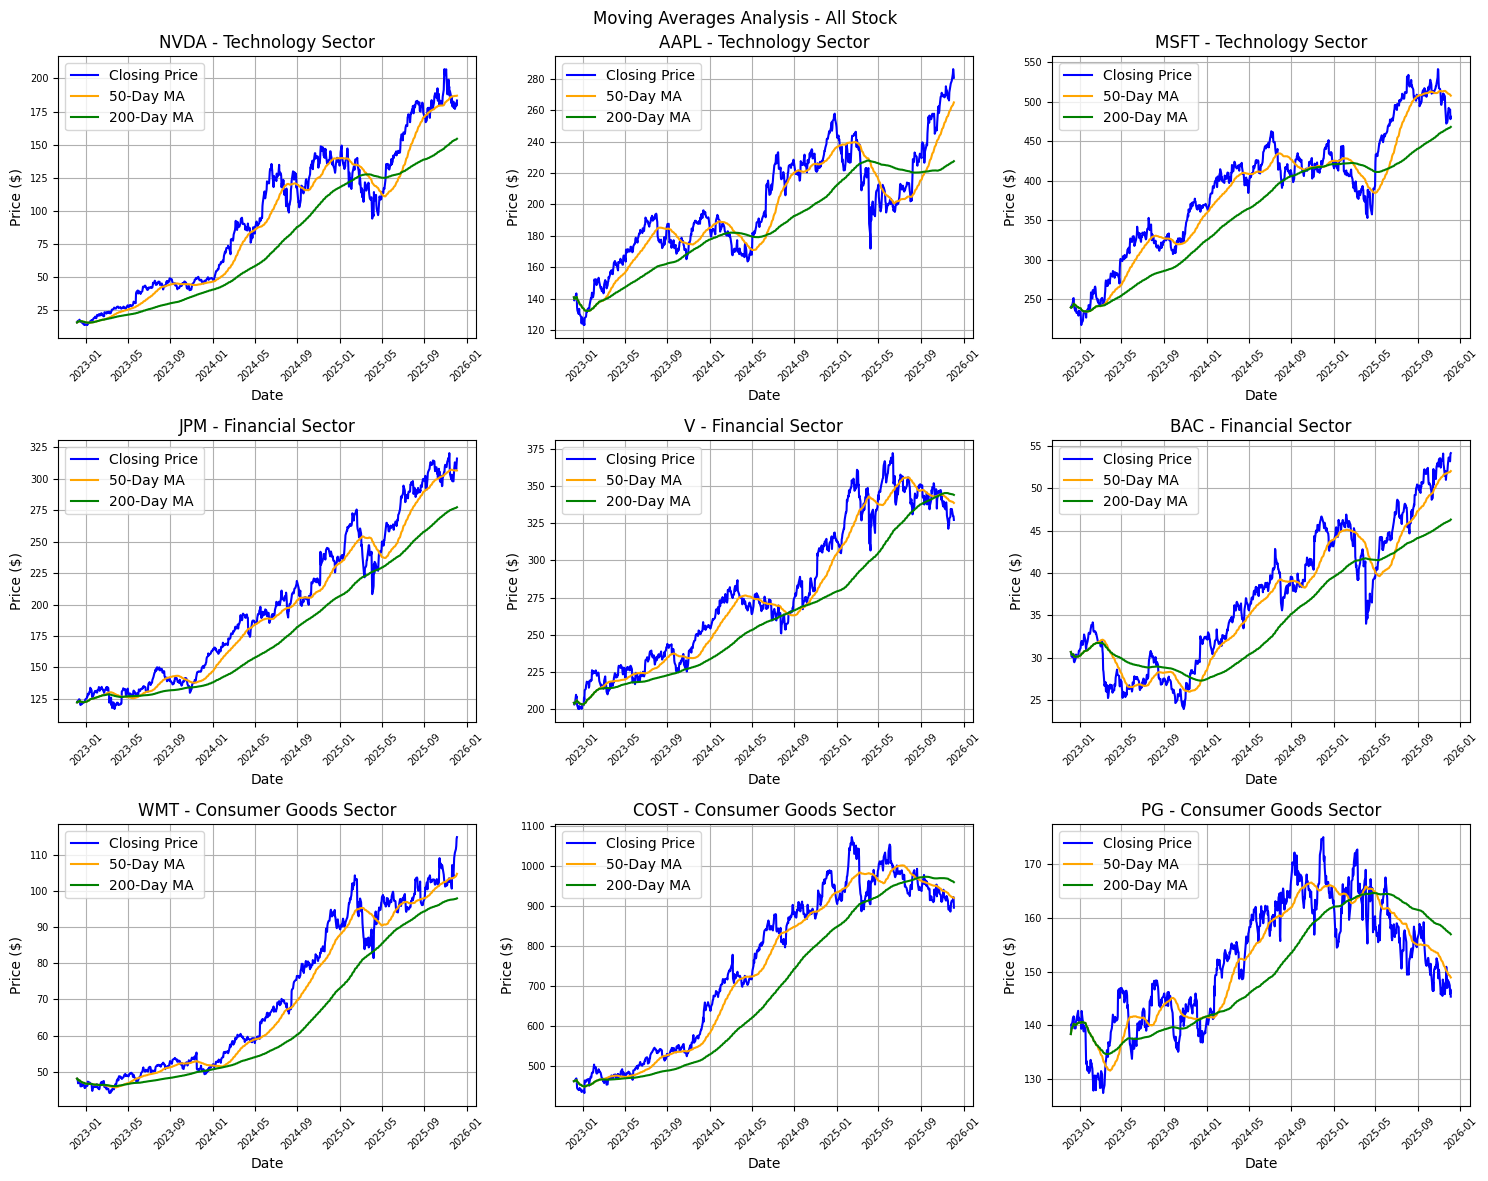

In [23]:
def moving_average_plot(all_data):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Moving Averages Analysis - All Stock')
    stock_list = []
    for sector, tickers in SECTORS.items():
        for ticker in tickers:
            if ticker in all_data:
                stock_list.append((sector, ticker, all_data[ticker]))

    for idx, (sector, ticker, df) in enumerate(stock_list):
        ax = axes[idx // 3, idx % 3]
        ax.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
        ax.plot(df['Date'], df['MA_50'], label='50-Day MA', color='orange')
        ax.plot(df['Date'], df['MA_200'], label='200-Day MA', color='green')

        ax.set_title(f"{ticker} - {sector} Sector")
        ax.set_xlabel('Date')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid()
        ax.tick_params(axis='both', labelsize=7)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

moving_average_plot(all_data)

### Sector Return Plot

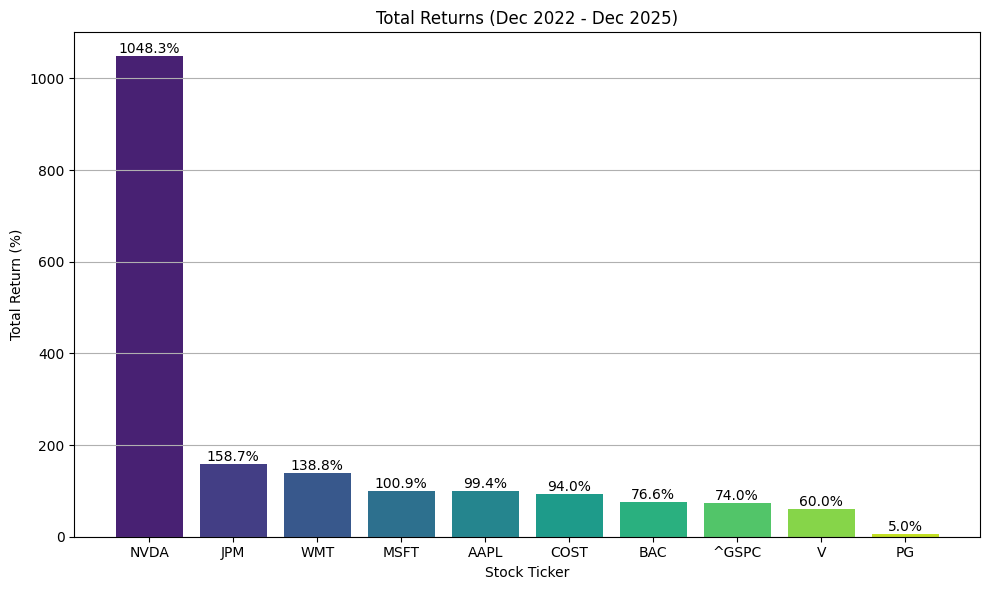

In [27]:
def sector_returns_plot():
    summary_df = pd.read_csv("../results/data/summary_statistics.csv")

    fig, ax = plt.subplots(figsize=(10, 6))

    plot_df = summary_df.sort_values(by='Total_Return_%', ascending=False)
    
    bars = ax.bar(plot_df['Ticker'], plot_df['Total_Return_%'], color=sns.color_palette("viridis", len(plot_df)))

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

    ax.set_title("Total Returns (Dec 2022 - Dec 2025)")
    ax.set_xlabel('Stock Ticker')
    ax.set_ylabel('Total Return (%)')
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()
    plt.close()

sector_returns_plot()

### Risk-Return Plot

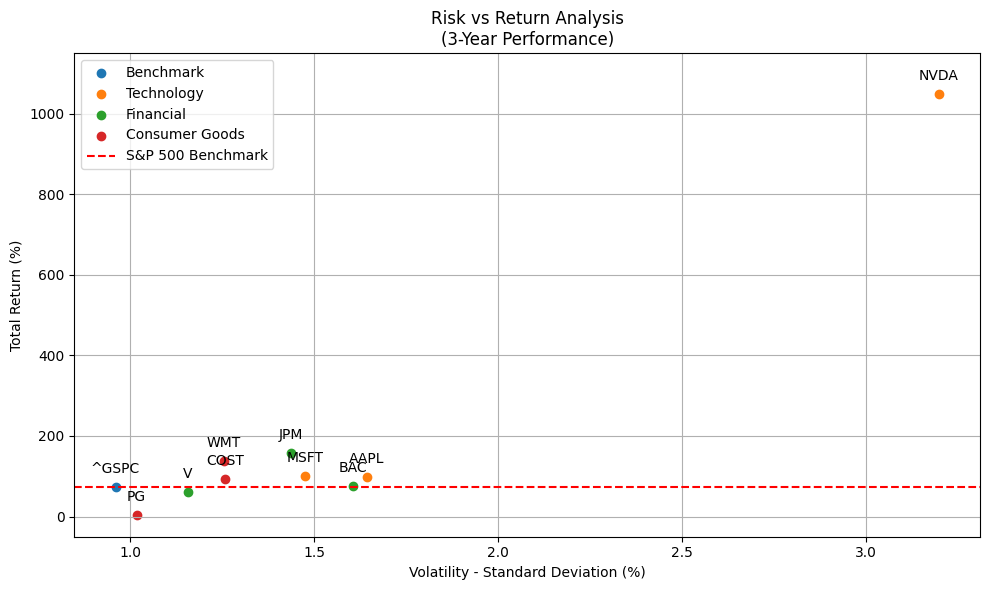

In [29]:
def plot_risk_return():
    summary_df = pd.read_csv("../results/data/summary_statistics.csv")

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for sector in summary_df['Sector'].unique():
        sector_df = summary_df[summary_df['Sector'] == sector]
        ax.scatter(sector_df['Volatility_%'], sector_df['Total_Return_%'], label=sector)

        for _, row in sector_df.iterrows():
            ax.annotate(row['Ticker'], (row['Volatility_%'], row['Total_Return_%']), textcoords="offset points", xytext=(0,10), ha='center')

    benchmark_return = summary_df[summary_df['Ticker'] == BENCHMARK]['Total_Return_%'].values[0]
    ax.axhline(y=benchmark_return, color='red', linestyle='--', label='S&P 500 Benchmark')

    ax.set_title("Risk vs Return Analysis\n(3-Year Performance)")
    ax.set_xlabel('Volatility - Standard Deviation (%)')
    ax.set_ylabel('Total Return (%)')
    ax.legend()
    ax.grid()
    ax.set_ylim(-50, 1150)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_risk_return()

### Correlation Heatmap

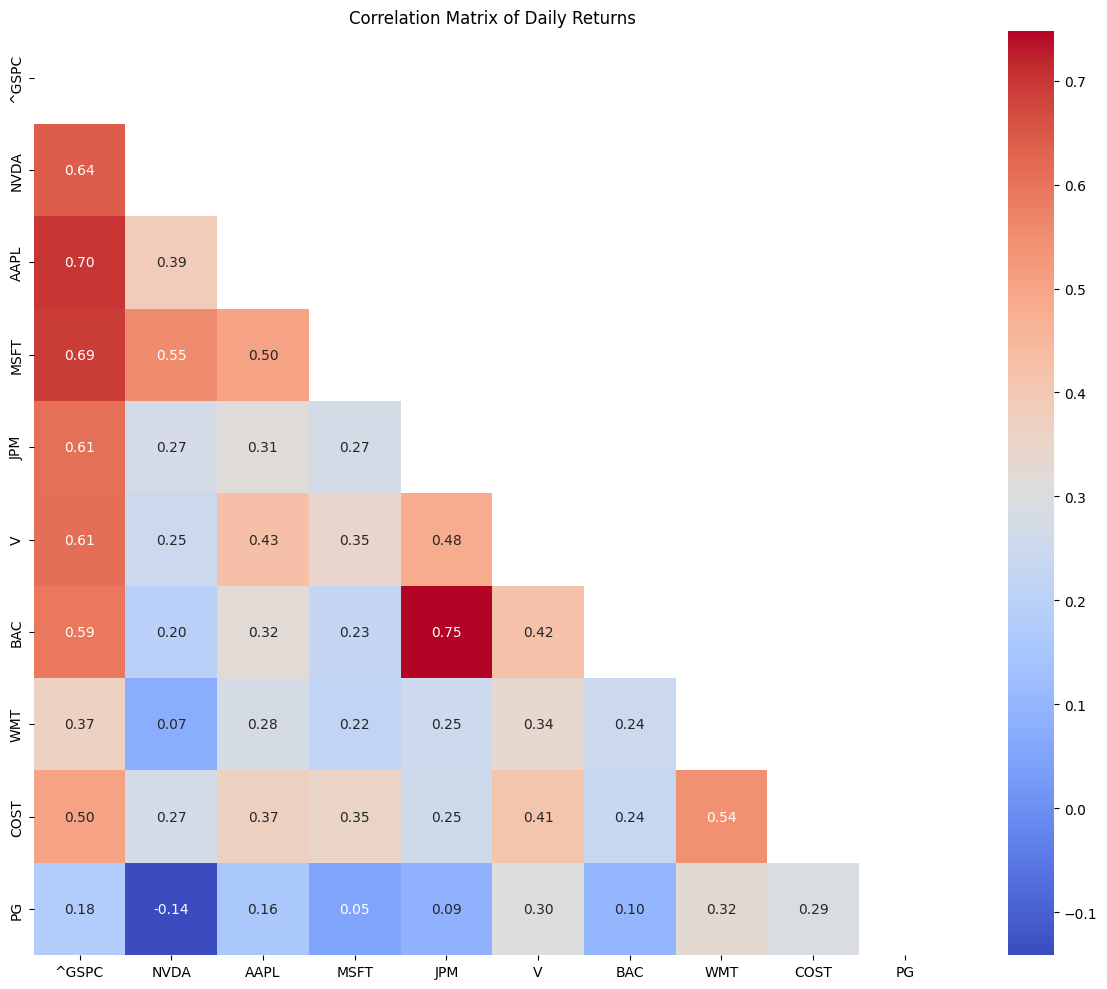

In [32]:
def plot_correlation_heatmap():
    corr_df = pd.read_csv("../results/data/correlation_matrix.csv", index_col=0)
    fig, ax = plt.subplots(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
    ax.set_title("Correlation Matrix of Daily Returns")
    plt.tight_layout()
    plt.show()
    plt.close()

plot_correlation_heatmap()

### Alpha Distribution Plot

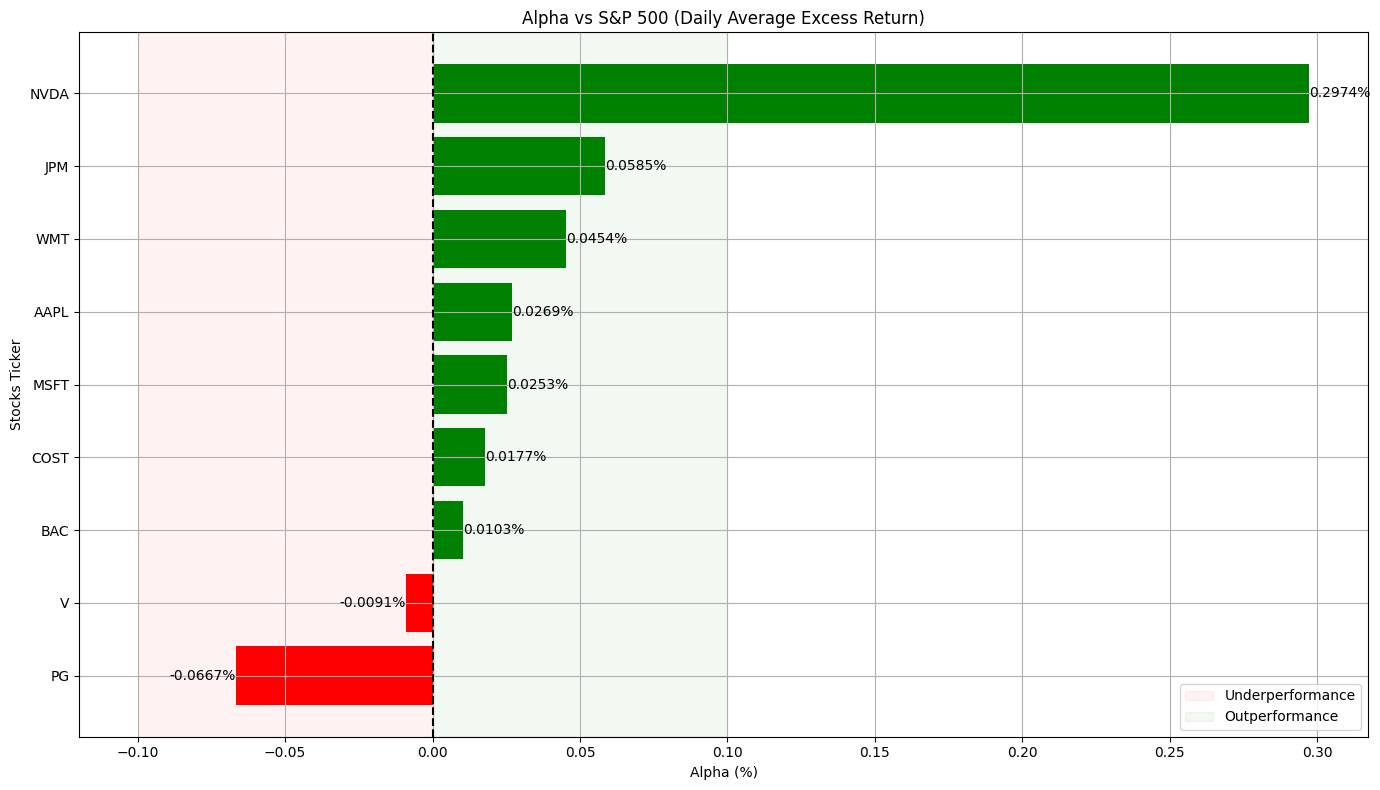

In [34]:
def alpha_distribution_plot():
    summary_df = pd.read_csv("../results/data/summary_statistics.csv")
    stocks_df = summary_df[summary_df['Ticker'] != BENCHMARK].copy()
    stocks_df = stocks_df.sort_values(by='Alpha_%', ascending=True)

    fig, ax = plt.subplots(figsize=(14, 8))

    bar_colors = ['red' if x < 0 else 'green' for x in stocks_df['Alpha_%']]

    bars = ax.barh(stocks_df['Ticker'], stocks_df['Alpha_%'], color=bar_colors)

    for bar, val in zip(bars, stocks_df['Alpha_%']):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2., f'{val:.4f}%', ha='left' if width > 0 else 'right', va='center')

    ax.axvline(x=0, color='black', linestyle='--')
    ax.axvspan(-0.1, 0, color='red', alpha=0.05, label='Underperformance')
    ax.axvspan(0, 0.1, color='green', alpha=0.05, label='Outperformance')
    ax.set_title("Alpha vs S&P 500 (Daily Average Excess Return)")
    ax.set_xlabel('Alpha (%)')
    ax.set_ylabel('Stocks Ticker')
    ax.grid()
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    plt.close()

alpha_distribution_plot()
